# **Markow chains**

## Juan Diego Tabares

## June 2024



In this exercise we develop a trading strategy based on a Markow chains approach. For this purpose, we will use three financial assets:

- An index following the S&P500 as a traditional investment carrier. In this case we use the ETF SPY.
- A pair of exchange currencies as a second traditional investment carrier. We will use the pair Euro-US dollar.
- An alternative investment asset. We use Bitcoin to include a volatile, non-traditional, asset.  

We will estimate the probability of the changing state (up or down) of the price in the next period based on its current changing state.

$$
  P(up|up)=a 
$$ 
$$ 
  P(down|up)=1-a
$$ 
$$
  P(up|down)=b 
$$ 
$$ 
  P(down|down)=1-b
$$ 

In [1]:
# Libraries

import numpy as np
import pandas as pd
import yfinance as yf
import tools_kit as kit
import matplotlib.pyplot as plt
import warnings 

In [2]:
# Settings the warnings to be ignored 

warnings.filterwarnings('ignore') 

In [3]:
tickers = ['SPY', 'BTC-USD', 'EURUSD=X']

In [4]:
# We get the data using my own library (tools_kit). In previous exercises it is explained how we use this.

data_prices = kit.get_price(tickers, '2004-01-01', '2024-06-15')

[*********************100%***********************]  3 of 3 completed


In [5]:
data_prices

,BTC-USD,EURUSD=X,SPY
Date,,,
2004-01-01,NaN,1.258194,NaN
2004-01-02,NaN,1.258194,75.387589
2004-01-05,NaN,1.268698,76.207680
2004-01-06,NaN,1.272103,76.282227
2004-01-07,NaN,1.264095,76.539787
...,...,...,...
2024-06-10,69512.281250,1.077888,533.937439
2024-06-11,67332.031250,1.076426,535.223328
2024-06-12,68241.187500,1.074033,539.619141


In [6]:
# Function to prepare the data frame that we will use for the strqtegy. We apply the strategy separately for each asset.

def df_Markov_chains(Ticker):
    df_prices = pd.DataFrame(data_prices[Ticker])
    df_prices['Weekday'] = df_prices.index.day_name()
    df_prices['Daily_Diff']=df_prices[Ticker].diff()
    df_prices['price_change'] = 0
    df_prices['price_change'] = df_prices['Daily_Diff'].apply(lambda x: '1' if x > 0 else ('-1' if x < 0 else ''))
    return df_prices

In [57]:
# Function to define the state of the price en each period. We consider two states: up and down, considering the current price and the price
## in the previous period. Nex to it, we create two columns indicating if the state change from up to dow, or from down to up.

def states_fn(df):
    states = df['price_change']
    states.replace('', np.nan, inplace=True)
    states =states.dropna()
    states = pd.DataFrame(states)
    # Create a shifted column to compare current state with the next state
    states['next_state'] = states['price_change'].shift(-1)
    # Create the 'count_1_to_minus1' column using vectorized operations
    states['count_1_to_minus1'] = ((states['price_change'] == '1') & (states['next_state'] == '-1')).astype(int)
    # Drop the helper 'next_state' column
    states.drop(columns=['next_state'], inplace=True)
    # Create a shifted column to compare current state with the next state
    states['next_state'] = states['price_change'].shift(-1)
    # Create the 'count_minus1_to_1' column using vectorized operations
    states['count_minus1_to_1'] = ((states['price_change'] == '-1') & (states['next_state'] == '1')).astype(int)
    # Drop the helper 'next_state' column
    states.drop(columns=['next_state'], inplace=True)

    return states

## S&P500 exercise 

In [8]:
SPY_prices = df_Markov_chains('SPY')
SPY_prices

,SPY,Weekday,Daily_Diff,price_change
Date,,,,
2004-01-01,NaN,Thursday,NaN,
2004-01-02,75.387589,Friday,NaN,
2004-01-05,76.207680,Monday,0.820091,1
2004-01-06,76.282227,Tuesday,0.074547,1
2004-01-07,76.539787,Wednesday,0.257561,1
...,...,...,...,...
2024-06-10,533.937439,Monday,NaN,
2024-06-11,535.223328,Tuesday,1.285889,1
2024-06-12,539.619141,Wednesday,4.395813,1


In [9]:
states_SPY = states_fn(SPY_prices)['2024-01-01':]
states_SPY

,price_change,count_1_to_minus1,count_minus1_to_1
Date,,,
2024-01-03,-1,0,0
2024-01-04,-1,0,1
2024-01-05,1,1,0
2024-01-09,-1,0,1
2024-01-10,1,1,0
...,...,...,...
2024-06-07,-1,0,1
2024-06-11,1,0,0
2024-06-12,1,0,0


At this point we compute the probablity of the price changing its state or remaining it unchanged, only considering its current state. We use previous proportions as probabilities.

In [10]:
print('Number of up days:', sum(states_SPY['price_change'] == "1"))
print('Number of down days:', sum(states_SPY['price_change'] == "-1"))

Number of up days: 53
Number of down days: 38


In [11]:
print('up to up:', sum(states_SPY['price_change'] == "1") - states_SPY['count_1_to_minus1'].sum())
print('up to down:', states_SPY['count_1_to_minus1'].sum())
print('down to up:', states_SPY['count_minus1_to_1'].sum())
print('down to down:', sum(states_SPY['price_change'] == "-1") - states_SPY['count_minus1_to_1'].sum())

up to up: 32
up to down: 21
down to up: 22
down to down: 16


In [12]:
prob_up_to_up = (sum(states_SPY['price_change'] == "1") - states_SPY['count_1_to_minus1'].sum())/(sum(states_SPY['price_change'] == "1"))
prob_up_to_down = (states_SPY['count_1_to_minus1'].sum())/(sum(states_SPY['price_change'] == "1"))
prob_down_to_up = (states_SPY['count_minus1_to_1'].sum())/(sum(states_SPY['price_change'] == "-1"))
prob_down_down = (sum(states_SPY['price_change'] == "-1") - states_SPY['count_minus1_to_1'].sum())/(sum(states_SPY['price_change'] == "-1"))

In [13]:
# Define the transition matrix

transition_matrix = np.array([
    [prob_up_to_up, prob_up_to_down],
    [prob_down_to_up, prob_down_down]])

transition_matrix

array([[0.60377358, 0.39622642],
       [0.57894737, 0.42105263]])

In [14]:
# Function to simulate a single run of the Markov chain. We run the simulation states with 0 as up and 1 as down

def simulate_markov_chain(transition_matrix, initial_state, steps):
    state = initial_state
    states = [state]

    for _ in range(steps):
        state = np.random.choice([0, 1], p=transition_matrix[state])
        states.append(state)
    
    return states

In [15]:
# Function to replicate the simulation of the Markox chain

def replicate_simulations(transition_matrix, initial_state, steps, replications):
    all_simulations = []

    for _ in range(replications):
        simulation = simulate_markov_chain(transition_matrix, initial_state, steps)
        all_simulations.append(simulation)
    
    return all_simulations

In [16]:
# Function to analyze the simulations

def analyze_simulations(all_simulations):
    df = pd.DataFrame(all_simulations)
    mean_state = df.mean(axis=0)
    median_state = df.median(axis=0)
    
    return mean_state, median_state

In [17]:
# Parameters for the simulations

initial_state = 0  # 'up' as 0 and 'down' as 1
steps = 5  # Number of steps in each simulation
replications = 10000  # Number of replications

In [18]:
# Run the simulations

all_simulations = replicate_simulations(transition_matrix, initial_state, steps, replications)

In [19]:
# Analyze the results

mean_state, median_state = analyze_simulations(all_simulations)

The result for the next 5 periods indicates that the price will continue going up.

In [20]:
print("Mean state for each step:")
print(mean_state)

print("\nMedian state for each step:")
print(median_state)

Mean state for each step:
0    0.0000
1    0.3903
2    0.4069
3    0.4005
4    0.4025
5    0.4036
dtype: float64

Median state for each step:
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
dtype: float64


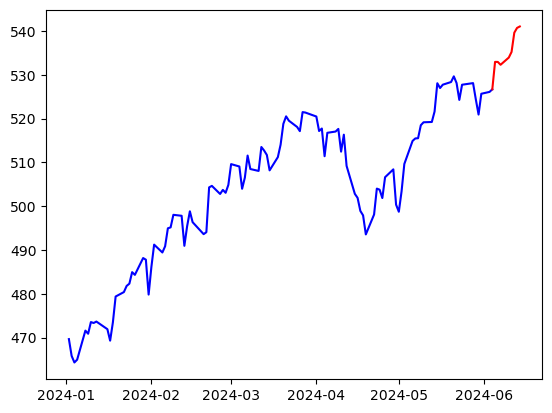

In [21]:
plt.plot(SPY_prices['SPY'].dropna()['2024-01-01':'2024-06-04'], color='blue')
plt.plot(SPY_prices['SPY'].dropna()['2024-06-04':], color='red') 
plt.show() 

In [22]:
SPY_prices['SPY']['2024-06-04':]

Date
2024-06-04    526.690857
2024-06-05    532.950623
2024-06-06    532.940674
2024-06-07    532.292786
2024-06-08           NaN
2024-06-09           NaN
2024-06-10    533.937439
2024-06-11    535.223328
2024-06-12    539.619141
2024-06-13    540.705627
2024-06-14    541.034607
Name: SPY, dtype: float64

As a contrast, we test the strategy for SPY in a bearish period.

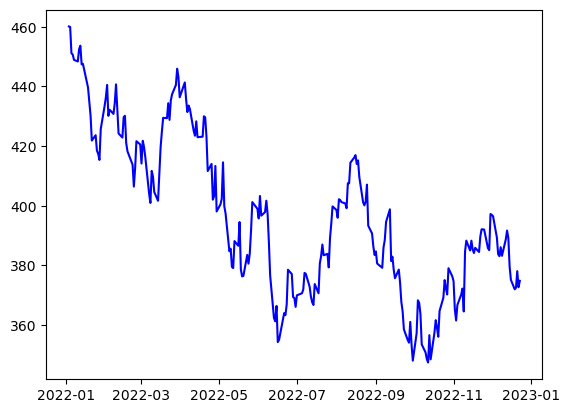

In [23]:
plt.plot(SPY_prices['SPY'].dropna()['2022-01-01':'2022-12-23'], color='blue')

In [24]:
states_SPY_down = states_fn(SPY_prices['2022-01-01':'2022-12-23'])
states_SPY_down

,price_change,count_1_to_minus1,count_minus1_to_1
Date,,,
2022-01-04,-1,0,0
2022-01-05,-1,0,0
2022-01-06,-1,0,0
2022-01-07,-1,0,1
2022-01-11,1,0,0
...,...,...,...
2022-12-16,-1,0,1
2022-12-20,1,0,0
2022-12-21,1,1,0


In [25]:
print('Number of up days:', sum(states_SPY_down['price_change'] == "1"))
print('Number of down days:', sum(states_SPY_down['price_change'] == "-1"))

print('up to up:', sum(states_SPY_down['price_change'] == "1") - states_SPY_down['count_1_to_minus1'].sum())
print('up to down:', states_SPY_down['count_1_to_minus1'].sum())
print('down to up:', states_SPY_down['count_minus1_to_1'].sum())
print('down to down:', sum(states_SPY_down['price_change'] == "-1") - states_SPY_down['count_minus1_to_1'].sum())

Number of up days: 87
Number of down days: 107
up to up: 39
up to down: 48
down to up: 49
down to down: 58


In [26]:
prob_up_to_up = (sum(states_SPY_down['price_change'] == "1") - states_SPY_down['count_1_to_minus1'].sum())/(sum(states_SPY_down['price_change'] == "1"))
prob_up_to_down = (states_SPY_down['count_1_to_minus1'].sum())/(sum(states_SPY_down['price_change'] == "1"))
prob_down_to_up = (states_SPY_down['count_minus1_to_1'].sum())/(sum(states_SPY_down['price_change'] == "-1"))
prob_down_down = (sum(states_SPY_down['price_change'] == "-1") - states_SPY_down['count_minus1_to_1'].sum())/(sum(states_SPY_down['price_change'] == "-1"))

In [27]:
# Define the transition matrix

transition_matrix = np.array([
    [prob_up_to_up, prob_up_to_down],
    [prob_down_to_up, prob_down_down]])

transition_matrix

array([[0.44827586, 0.55172414],
       [0.45794393, 0.54205607]])

In [28]:
# Parameters. We change the initial state to down

initial_state = 1  # 'up' as 0 and 'down' as 1
steps = 5  # Number of steps in each simulation
replications = 10000  # Number of replications

In [29]:
# Run the simulations

all_simulations = replicate_simulations(transition_matrix, initial_state, steps, replications)

In [30]:
# Analyze the results

mean_state, median_state = analyze_simulations(all_simulations)

The result indicates the price will continue going down for the next 5 periods.

In [31]:
print("Mean state for each step:")
print(mean_state)

print("\nMedian state for each step:")
print(median_state)

Mean state for each step:
0    1.0000
1    0.5303
2    0.5522
3    0.5533
4    0.5355
5    0.5504
dtype: float64

Median state for each step:
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
dtype: float64


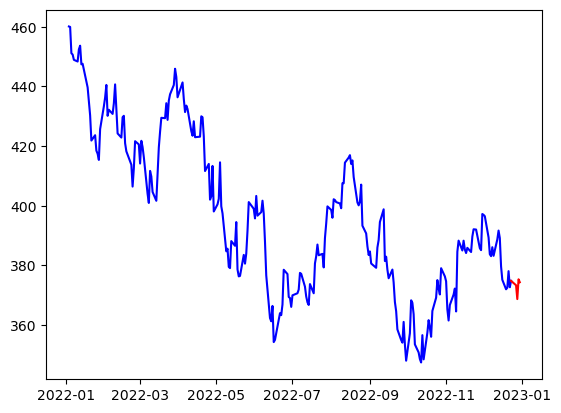

In [32]:
plt.plot(SPY_prices['SPY'].dropna()['2022-01-01':'2022-12-23'], color='blue')
plt.plot(SPY_prices['SPY'].dropna()['2022-12-23':'2022-12-31'], color='red') 
plt.show() 

In [33]:
SPY_prices['SPY']['2022-12-23':'2022-12-31']

Date
2022-12-23    374.799988
2022-12-24           NaN
2022-12-25           NaN
2022-12-26           NaN
2022-12-27    373.321960
2022-12-28    368.682404
2022-12-29    375.318787
2022-12-30    374.330109
2022-12-31           NaN
Name: SPY, dtype: float64

## Bitcoin exercise 

In [34]:
BTC_prices = df_Markov_chains('BTC-USD')
BTC_prices

,BTC-USD,Weekday,Daily_Diff,price_change
Date,,,,
2004-01-01,NaN,Thursday,NaN,
2004-01-02,NaN,Friday,NaN,
2004-01-05,NaN,Monday,NaN,
2004-01-06,NaN,Tuesday,NaN,
2004-01-07,NaN,Wednesday,NaN,
...,...,...,...,...
2024-06-10,69512.281250,Monday,-135.710938,-1
2024-06-11,67332.031250,Tuesday,-2180.250000,-1
2024-06-12,68241.187500,Wednesday,909.156250,1


In [35]:
states_BTC = states_fn(BTC_prices)['2024-01-01':]
states_BTC

,price_change,count_1_to_minus1,count_minus1_to_1
Date,,,
2024-01-01,1,0,0
2024-01-02,1,1,0
2024-01-03,-1,0,1
2024-01-04,1,1,0
2024-01-05,-1,0,0
...,...,...,...
2024-06-10,-1,0,0
2024-06-11,-1,0,1
2024-06-12,1,1,0


In [36]:
print('Number of up days:', sum(states_BTC['price_change'] == "1"))
print('Number of down days:', sum(states_BTC['price_change'] == "-1"))

Number of up days: 88
Number of down days: 78


In [37]:
print('up to up:', sum(states_BTC['price_change'] == "1") - states_BTC['count_1_to_minus1'].sum())
print('up to down:', states_BTC['count_1_to_minus1'].sum())
print('down to up:', states_BTC['count_minus1_to_1'].sum())
print('down to down:', sum(states_BTC['price_change'] == "-1") - states_BTC['count_minus1_to_1'].sum())

up to up: 43
up to down: 45
down to up: 44
down to down: 34


In [38]:
prob_up_to_up = (sum(states_BTC['price_change'] == "1") - states_BTC['count_1_to_minus1'].sum())/(sum(states_BTC['price_change'] == "1"))
prob_up_to_down = (states_BTC['count_1_to_minus1'].sum())/(sum(states_BTC['price_change'] == "1"))
prob_down_to_up = (states_BTC['count_minus1_to_1'].sum())/(sum(states_BTC['price_change'] == "-1"))
prob_down_down = (sum(states_BTC['price_change'] == "-1") - states_BTC['count_minus1_to_1'].sum())/(sum(states_BTC['price_change'] == "-1"))

In [39]:
# Define the transition matrix

transition_matrix = np.array([
    [prob_up_to_up, prob_up_to_down],
    [prob_down_to_up, prob_down_down]])

In [40]:
# Parameters. We change the initial state to up

initial_state = 0  # 'up' as 0 and 'down' as 1
steps = 5  # Number of steps in each simulation
replications = 10000  # Number of replications

In [41]:
# Run the simulations

all_simulations = replicate_simulations(transition_matrix, initial_state, steps, replications)

In [42]:
# Analyze the results

mean_state, median_state = analyze_simulations(all_simulations)

The result indicates the price will go up on the first step and then it will go down.

In [43]:
print("Mean state for each step:")
print(mean_state)

print("\nMedian state for each step:")
print(median_state)

Mean state for each step:
0    0.0000
1    0.5063
2    0.4781
3    0.4768
4    0.4704
5    0.4784
dtype: float64

Median state for each step:
0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
5    0.0
dtype: float64


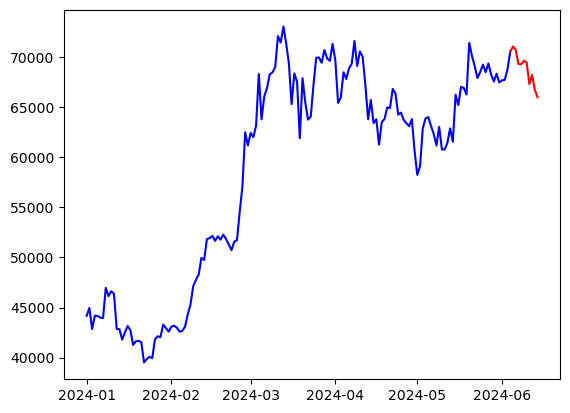

In [44]:
plt.plot(BTC_prices['BTC-USD']['2024-01-01':'2024-06-04'], color='blue')
plt.plot(BTC_prices['BTC-USD']['2024-06-04':], color='red') 
plt.show() 

In [45]:
BTC_prices['BTC-USD']['2024-06-04':]

Date
2024-06-04    70567.765625
2024-06-05    71082.820312
2024-06-06    70757.164062
2024-06-07    69342.585938
2024-06-08    69305.773438
2024-06-09    69647.992188
2024-06-10    69512.281250
2024-06-11    67332.031250
2024-06-12    68241.187500
2024-06-13    66756.398438
2024-06-14    66011.093750
Name: BTC-USD, dtype: float64

## Pair EUR-USD exercise

In [46]:
EURUSD_prices = df_Markov_chains('EURUSD=X')
EURUSD_prices

,EURUSD=X,Weekday,Daily_Diff,price_change
Date,,,,
2004-01-01,1.258194,Thursday,NaN,
2004-01-02,1.258194,Friday,0.000000,
2004-01-05,1.268698,Monday,0.010504,1
2004-01-06,1.272103,Tuesday,0.003405,1
2004-01-07,1.264095,Wednesday,-0.008008,-1
...,...,...,...,...
2024-06-10,1.077888,Monday,NaN,
2024-06-11,1.076426,Tuesday,-0.001462,-1
2024-06-12,1.074033,Wednesday,-0.002393,-1


In [47]:
states_EURUSD = states_fn(EURUSD_prices)['2024-01-01':]
states_EURUSD

,price_change,count_1_to_minus1,count_minus1_to_1
Date,,,
2024-01-02,-1,0,0
2024-01-03,-1,0,0
2024-01-04,-1,0,1
2024-01-05,1,0,0
2024-01-09,1,1,0
...,...,...,...
2024-06-07,1,1,0
2024-06-11,-1,0,0
2024-06-12,-1,0,1


In [48]:
print('Number of up days:', sum(states_EURUSD['price_change'] == "1"))
print('Number of down days:', sum(states_EURUSD['price_change'] == "-1"))

Number of up days: 43
Number of down days: 52


In [49]:
print('up to up:', sum(states_EURUSD['price_change'] == "1") - states_EURUSD['count_1_to_minus1'].sum())
print('up to down:', states_EURUSD['count_1_to_minus1'].sum())
print('down to up:', states_EURUSD['count_minus1_to_1'].sum())
print('down to down:', sum(states_EURUSD['price_change'] == "-1") - states_EURUSD['count_minus1_to_1'].sum())

up to up: 19
up to down: 24
down to up: 24
down to down: 28


In [50]:
prob_up_to_up = (sum(states_EURUSD['price_change'] == "1") - states_EURUSD['count_1_to_minus1'].sum())/(sum(states_EURUSD['price_change'] == "1"))
prob_up_to_down = (states_EURUSD['count_1_to_minus1'].sum())/(sum(states_EURUSD['price_change'] == "1"))
prob_down_to_up = (states_EURUSD['count_minus1_to_1'].sum())/(sum(states_EURUSD['price_change'] == "-1"))
prob_down_down = (sum(states_EURUSD['price_change'] == "-1") - states_EURUSD['count_minus1_to_1'].sum())/(sum(states_EURUSD['price_change'] == "-1"))

In [51]:
# Define the transition matrix

transition_matrix = np.array([
    [prob_up_to_up, prob_up_to_down],
    [prob_down_to_up, prob_down_down]])

In [52]:
# Run the simulations

all_simulations = replicate_simulations(transition_matrix, initial_state, steps, replications)

In [53]:
# Analyze the results

mean_state, median_state = analyze_simulations(all_simulations)

The result indicates that the price will continue going up for the next 5 periods.

In [54]:
print("Mean state for each step:")
print(mean_state)

print("\nMedian state for each step:")
print(median_state)

Mean state for each step:
0    0.0000
1    0.5560
2    0.5485
3    0.5506
4    0.5478
5    0.5439
dtype: float64

Median state for each step:
0    0.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
dtype: float64


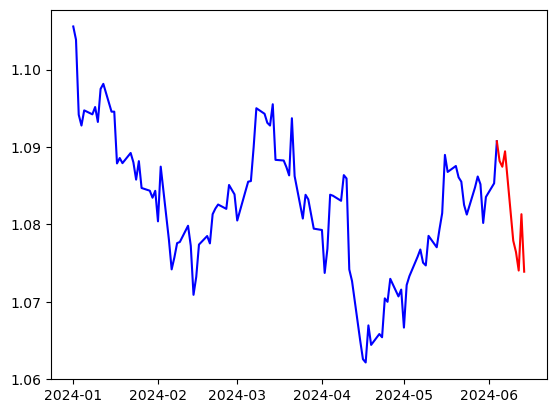

In [55]:
plt.plot(EURUSD_prices['EURUSD=X'].dropna()['2024-01-01':'2024-06-04'], color='blue')
plt.plot(EURUSD_prices['EURUSD=X'].dropna()['2024-06-04':], color='red') 
plt.show() 

In [56]:
EURUSD_prices['EURUSD=X']['2024-06-04':]

Date
2024-06-04    1.090739
2024-06-05    1.088187
2024-06-06    1.087453
2024-06-07    1.089443
2024-06-08         NaN
2024-06-09         NaN
2024-06-10    1.077888
2024-06-11    1.076426
2024-06-12    1.074033
2024-06-13    1.081315
2024-06-14    1.073883
Name: EURUSD=X, dtype: float64